In [1]:
FN='160306-FCN_tutorial'

In [2]:
from utils import Dataset, params, Nt, Nv, Ns, temp_dir, awscp
Na = Nt+Nv+Ns
Nt, Nv, Ns

(500, 200, 440)

In [3]:
import dicom, lmdb, cv2, re, sys
import os, fnmatch, shutil, subprocess
from IPython.utils import io
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
from matplotlib import image
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') # we ignore a RuntimeWarning produced from dividing by zero

CAFFE_ROOT = "/home/ubuntu/caffe_FCN/"
caffe_path = os.path.join(CAFFE_ROOT, "python")
if caffe_path not in sys.path:
    sys.path.insert(0, caffe_path)

import caffe
import json

In [4]:
%%bash
cat > fcn_deploy.prototxt <<EOF

name: "FCN"
force_backward: true
input: "data"
# We will manipulate the input_dim fields below in Python during testing. They appear here only for syntactic reasons.
input_dim: 1
input_dim: 1
input_dim: 1
input_dim: 1
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 100
    pad: 50
    kernel_size: 5
    group: 1
    stride: 2
    weight_filler {
      type: "gaussian"
      mean: 0.0
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 200
    pad: 0
    kernel_size: 5
    group: 1
    stride: 2
    weight_filler {
      type: "gaussian"
      mean: 0.0
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu2"
  type: "ReLU"
  bottom: "conv2"
  top: "conv2"
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv3"
  type: "Convolution"
  bottom: "pool2"
  top: "conv3"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 300
    pad: 0
    kernel_size: 3
    group: 1
    stride: 1
    weight_filler {
      type: "gaussian"
      mean: 0.0
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu3"
  type: "ReLU"
  bottom: "conv3"
  top: "conv3"
}
layer {
  name: "conv4"
  type: "Convolution"
  bottom: "conv3"
  top: "conv4"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 300
    pad: 0
    kernel_size: 3
    group: 1
    stride: 1
    weight_filler {
      type: "gaussian"
      mean: 0.0
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu4"
  type: "ReLU"
  bottom: "conv4"
  top: "conv4"
}
# layer {
#   name: "drop"
#   type: "Dropout"
#   bottom: "conv4"
#   top: "conv4"
#   dropout_param {
#     dropout_ratio: 0.5
#   }
# }
layer {
  name: "score_classes"
  type: "Convolution"
  bottom: "conv4"
  top: "score_classes"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 2
    pad: 0
    kernel_size: 1
    group: 1
    stride: 1
    weight_filler {
      type: "gaussian"
      mean: 0.0
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "upscore"
  type: "Deconvolution"
  bottom: "score_classes"
  top: "upscore"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 2
    bias_term: true
    kernel_size: 31
    pad: 8
    stride: 16
    weight_filler { type: "bilinear" }
    bias_filler { type: "constant" value: 0.1 }
  }
}
layer {
  name: "score"
  type: "Crop"
  bottom: "upscore"
  bottom: "data"
  top: "score"
}
layer {
  name: "prob"
  type: "Softmax"
  bottom: "score"
  top: "prob"
}
EOF

In [5]:
!rm -rf {temp_dir}/output.fcn/
!mkdir {temp_dir}/output.fcn/

In [6]:
from scipy.fftpack import fftn, ifftn
import cv2

def get_H1(images):
    # filter first harmonic for each pixel
    ff = fftn(images)
    first_harmonic = ff[1, :, :]
    result = np.absolute(ifftn(first_harmonic))
    # blur between pixels
    result = cv2.GaussianBlur(result, (5, 5), 0)
    return result

def get_H1_all_masks(all_masks):
    T = len(all_masks)
    S = len(all_masks[0])
    H,W = all_masks[0][0].shape
    res = []
    for s in range(S):
        masks = np.zeros((T,H,W))
        for t in range(T):
            masks[t,:,:] = all_masks[t][s]
        res.append(get_H1(masks))

    return np.array(res)

In [7]:
from pylab import cm
MEAN_VALUE = 77
THRESH = 0.5

def calc_all_areas(images):
    (num_images, times, _, _) = images.shape
    
    all_masks = [{} for i in range(times)]
    all_areas = [{} for i in range(times)]
    for i in range(times):
        for j in range(num_images):
            # print 'Calculating area for time %d and slice %d...' % (i, j)
            img = images[j][i]
            in_ = np.expand_dims(img, axis=0)
            in_ -= np.array([MEAN_VALUE])
            net.blobs['data'].reshape(1, *in_.shape)
            net.blobs['data'].data[...] = in_
            net.forward()
            prob = net.blobs['prob'].data
            obj = prob[0][1]
            preds = np.where(obj > THRESH, 1, 0)
            all_masks[i][j] = obj.copy()
            all_areas[i][j] = np.count_nonzero(preds)

    return all_masks, all_areas

def calc_all_areas_batch(images):
    (num_images, times, _, _) = images.shape
    
    all_masks = [{} for i in range(times)]
    all_areas = [{} for i in range(times)]
    for i in range(times):
        batch = []
        s = None
        for j in range(num_images):
            # print 'Calculating area for time %d and slice %d...' % (i, j)
            img = images[j][i]
            if s is None:
                s = img.shape
            assert img.shape == s
            in_ = np.expand_dims(img, axis=0)
#             in_ -= np.array([MEAN_VALUE])
            batch.append(in_ - np.array([MEAN_VALUE]))
        batch = np.array(batch)
        net.blobs['data'].reshape(*batch.shape)
        net.blobs['data'].data[...] = batch
        net.forward()
        prob = net.blobs['prob'].data
        for j in range(num_images):
            obj = prob[j][1]
            preds = np.where(obj > THRESH, 1, 0)
            all_masks[i][j] = obj.copy()
            all_areas[i][j] = np.count_nonzero(preds)

    return all_masks, all_areas

def calc_total_volume(areas, area_multiplier, dist):
    slices = np.array(sorted(areas.keys()))
    modified = [areas[i] * area_multiplier for i in slices]
    vol = 0
    for i in slices[:-1]:
        a, b = modified[i], modified[i+1]
        subvol = (dist/3.0) * (a + np.sqrt(a*b) + b)
        vol += subvol / 1000.0  # conversion to mL
    return vol

def save_masks_to_dir(dataset, h1s):
    mask = np.clip(25*h1s,0,255).astype(np.uint8)
    if not os.path.exists(os.path.join(temp_dir,'output.fcn',str(dataset.name))):
        os.mkdir(os.path.join(temp_dir,'output.fcn',str(dataset.name)))
    np.savez(os.path.join(temp_dir,'output.fcn',str(dataset.name),'h1s'), mask)

def segment_dataset(dataset, images):
    # shape: num slices, num snapshots, rows, columns
    print 'Calculating areas...'
    all_masks, all_areas = calc_all_areas_batch(images)
    print 'Calculating volumes...'
    area_totals = [calc_total_volume(a, dataset.area, dataset.dist)
                   for a in all_areas]
    print 'Calculating EF...'
    edv = max(area_totals)
    edi = np.argmax(area_totals)
    esv = min(area_totals)
    esi = np.argmin(area_totals)
    ef = (edv - esv) / edv
    print 'Done, EF is {:0.4f}'.format(ef),
    print esv,edv

    h1s = get_H1_all_masks(all_masks)
    save_masks_to_dir(dataset, h1s)
    
    output = {}
    output["edv"] = edv
    output["esv"] = esv
    output["edi"] = edi
    output["esi"] = esi
    output["ef"] = ef
    output["areas"] = all_areas
    if not os.path.exists(os.path.join(temp_dir,'output.fcn',str(dataset.name))):
        os.mkdir(os.path.join(temp_dir,'output.fcn',str(dataset.name)))
    f = open(os.path.join(temp_dir,'output.fcn',str(dataset.name),'output.json'), "w")
    json.dump(output, f, indent=2)
    f.close()
    
    dataset.edv = edv
    dataset.esv = esv
    dataset.ef = ef
    dataset.edi = edi
    dataset.esi = esi

In [8]:
# edit this so it matches where you download the DSB data
DATA_PATH = temp_dir

caffe.set_mode_gpu()

In [9]:
!curl --cacert /etc/ssl/certs/ca-certificates.crt https://s3.amazonaws.com/udikaggle/dsb2/160206-FCN_model.model.gz > {temp_dir}/160206-FCN_model.model.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6736k  100 6736k    0     0  25.3M      0 --:--:-- --:--:-- --:--:-- 25.6M


In [10]:
!gunzip -f {temp_dir}/160206-FCN_model.model.gz

In [11]:
!ls -l {temp_dir}/160206-FCN_model.model

-rw-rw-r-- 1 ubuntu ubuntu 7432874 Mar  8 22:14 /mnt/data/160206-FCN_model.model


In [12]:
net = caffe.Net('fcn_deploy.prototxt', str(os.path.join(temp_dir,'160206-FCN_model.model')), caffe.TEST)

train_dir = os.path.join(DATA_PATH, 'train')

In [13]:
study=1000

In [14]:
dset = Dataset(study+1)

In [15]:
dset.load()

In [16]:
images_eq = dset.images.copy()
for i, imgs in enumerate(images_eq):
    for j, img in enumerate(imgs):
        images_eq[i,j] = cv2.equalizeHist(np.array(img * 255./img.max(), dtype = np.uint8))

In [17]:
all_masks, all_areas = calc_all_areas_batch(images_eq)

In [18]:
max_time = np.argmax([sum(a.values()) for a in all_areas])
max_time

2

In [19]:
max_slice = max(all_areas[max_time].items(), key=lambda x: x[1])[0]
max_slice

8

In [20]:
len(all_masks),all_masks[max_time][max_slice].shape

(30, (192, 256))

In [21]:
h1s = get_H1_all_masks(all_masks)

7.4880095208210875

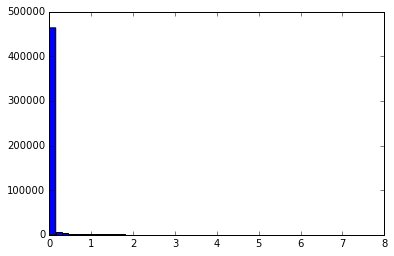

In [22]:
plt.hist(h1s.ravel(), bins=50)
h1s.max()

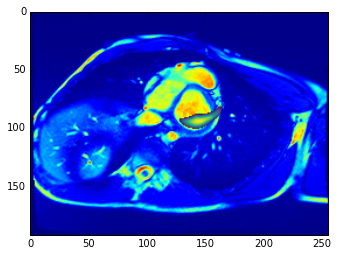

In [23]:
import copy
s = max_slice
t = max_time
my_cmap = copy.copy(plt.cm.get_cmap('viridis')) # get a copy of the gray color map
my_cmap.set_bad(alpha=0) # set how the colormap handles 'bad' values
mask = all_masks[t][s].copy()
h1s_s = h1s[s].copy()
h1s_s[h1s_s < h1s_s.max()*0.5] = np.nan

plt.imshow(dset.images[s,t])
plt.imshow(h1s_s, cmap=my_cmap)

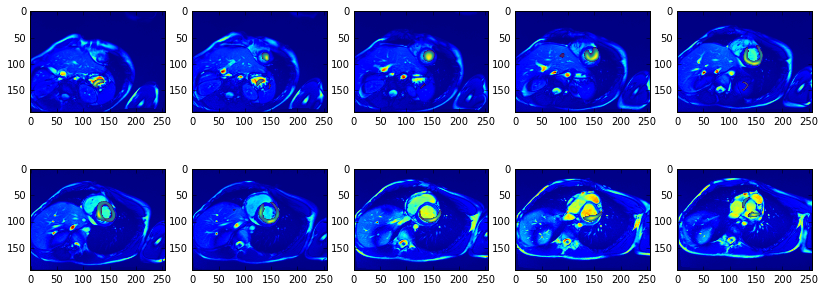

In [24]:
plt.figure(figsize=(14,8))
for i,ooo in enumerate(h1s):
    plt.subplot(len(h1s)//5+1,5,i+1)
    ooo = ooo.copy()
    ooo[ooo < ooo.max()*0.5] = np.nan
    plt.imshow(dset.images[i,t])
    plt.imshow(ooo, cmap=my_cmap)

In [25]:
preds = np.where(all_masks[5][6] > THRESH, 1, 0)
np.count_nonzero(preds)*dset.area*dset.dist*10/1000.

224.05528200000001

In [26]:
segment_dataset(dset, images_eq)

Calculating areas...
Calculating volumes...
Calculating EF...
Done, EF is 0.3831 116.147614528 188.270146723


In [27]:
dset.esi, dset.edi

(11, 2)

In [28]:
!rm -rf {temp_dir}/output.fcn

In [29]:
!mkdir {temp_dir}/output.fcn

In [30]:
%%time
# We capture all standard output from IPython so it does not flood the interface.
with io.capture_output() as captured:

    for s in range(Na):
        dset = Dataset(s+1)
        print 'Processing dataset %s...' % dset.name
        try:
            dset.load(S=-1)
            images_eq = dset.images.copy()
            for i, imgs in enumerate(images_eq):
                for j, img in enumerate(imgs):
                    images_eq[i,j] = cv2.equalizeHist(np.array(img * 255./img.max(), dtype = np.uint8))
            segment_dataset(dset, images_eq)
        except Exception as e:
            print '***ERROR***: Exception %s thrown by dataset %s' % (str(e), dset.name)

# We redirect the captured stdout to a log file on disk.
# This log file is very useful in identifying potential dataset irregularities that throw errors/exceptions in the code.
with open(os.path.join(temp_dir,'logs.fcn.txt'), 'w') as f:
    f.write(captured.stdout)

CPU times: user 2h 14min 55s, sys: 34min 18s, total: 2h 49min 13s
Wall time: 3h 1min 28s


track progress with 
```
ls -1 {temp_dir}/output.fcn | wc -l
```

In [31]:
fn = FN+'.output.fcn.tgz'
!cd {temp_dir} ; tar cfz {fn} output.fcn/

In [32]:
awscp(fn, upload=True)